In [41]:
import json 
import os
import pandas as pd
from tqdm import tqdm
import mapbox_vector_tile
from transformers import AutoTokenizer, AutoModelForCausalLM
import copy
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import operator as op

In [2]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

In [4]:
FILE_DIR = '../../map_generation/EDA'
ALL_VECTOR_DIR = '../../data/vector_tiles'
files = ['file1.json', 'file2.json', 'file3.json']

def mvt2json(path):
    with open(path, mode="rb") as mvt_file:
        contents = mvt_file.read()
        return  mapbox_vector_tile.decode(contents)

def read_json(path):
    file = open(os.path.join(FILE_DIR, path), "r")
    dic_json = json.load(file)
    return json.dumps(dic_json)

def read_single_string(path):
    file = open(os.path.join(FILE_DIR, path), "r")
    return file.read()

# # works for geojson from mvt
# def layer_tokens(path):
#     file = open(os.path.join(FILE_DIR, path), "r")
#     dic_json = json.load(file)
#     layers = {}
#     for feature in dic_json['features']:
#         if feature['properties']['vt_layer'] not in layers.keys():
#             layers[feature['properties']['vt_layer']] = []
#     return layers

In [7]:
berlin = pd.read_pickle('../../data/vector_tiles/Berlin, Germany.pkl')
path = os.path.join("../..", berlin.iloc[57]['tile'])
tile = mvt2json(path)

In [56]:
def random_float():
    return "0."+str(np.random.randint(1e14, 1e15))

def newPoint():
    return [random_float(), random_float()]

def newLineString(line):
    newline = []
    for _ in line:
        newpoint = newPoint()
        newline.append(newpoint)
    return newline
    
def newMultiLineString(lines):
    newlines = []
    for line in lines:
        newline = newLineString(line)
        newlines.append(newline)
    return newlines

def newMultiPolygon(polygons):
    newpolygons = []
    for polygon in polygons:
        newpolygon = newMultiLineString(polygon)
        newpolygons.append(newpolygon)
    return newpolygons

def replaceGeometry(geometry, geo_type):
    if geo_type == 'Point':
        geometry['coordinates'] = newPoint()
    elif geo_type == 'LineString':
        geometry['coordinates'] = newLineString(geometry['coordinates'])
    elif geo_type == 'MultiLineString':
        geometry['coordinates'] = newMultiLineString(geometry['coordinates'])
    elif geo_type == 'Polygon':
        geometry['coordinates'] = newMultiLineString(geometry['coordinates'])
    elif geo_type == 'MultiPolygon':
        geometry['coordinates'] = newMultiPolygon(geometry['coordinates'])
    else:
        print(geometry)

def floatify(layer):
    for feature in layer['features']:
        geometry = feature['geometry']
        geo_type = geometry['type']
        replaceGeometry(geometry, geo_type)
    return layer

In [62]:
def testNumberImpact(tiles_df, layer_name):

    tiles = {
        'int': [],
        'float': [],
        'difference': [],
        'perc difference': []
    }

    for idx, tile in tqdm(tiles_df.iterrows(), total=tiles_df.shape[0]):
        path = os.path.join("../..", tile['tile'])
        tile = mvt2json(path)
        if layer_name not in tile.keys():
            continue
        layer = tile[layer_name]
        layer_float = copy.deepcopy(layer)
        int_str = json.dumps(layer)
        floaty = floatify(layer_float)
        floaty_str = json.dumps(floaty)
        int_tokens = len(tokenizer.tokenize(int_str))
        float_tokens = len(tokenizer.tokenize(floaty_str))
        tiles['int'].append(int_tokens)
        tiles['float'].append(float_tokens)
        tiles['difference'].append(float_tokens - int_tokens)
        tiles['perc difference'].append((float_tokens - int_tokens)/float_tokens)
        
    return tiles
    
def visualizeSizeDiff(size):
    sorted_keys, sorted_vals = zip(*sorted(size.items(), key=op.itemgetter(1)))

    # almost verbatim from question
    boxplot = sns.boxplot(data=sorted_vals, width=.18)

    # category labels
    plt.xticks(plt.xticks()[0], sorted_keys)
    boxplot.set_yscale("log")
    boxplot.axhline(2048)
    plt.show()

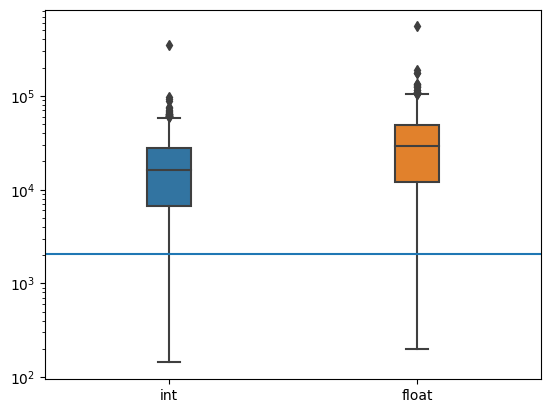

In [51]:
buildings = testNumberImpact(berlin, "building")

building_size = {
    'int': buildings['int'],
    'float': buildings['float']
}

visualizeSizeDiff(building_size)

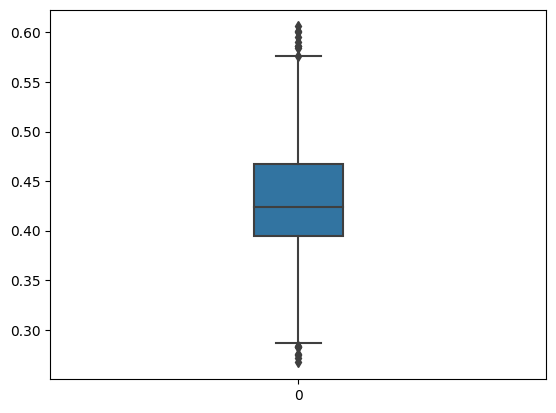

In [47]:
perc = pd.DataFrame(buildings['perc difference'])
boxplot = sns.boxplot(data=perc, width=.18)
plt.show()

100%|██████████| 6786/6786 [09:34<00:00, 11.82it/s]


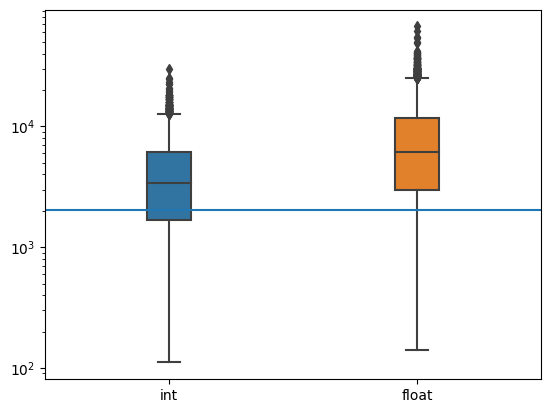

In [64]:
roads = testNumberImpact(berlin, "road")

road_size = {
    'int': roads['int'],
    'float': roads['float']
}

visualizeSizeDiff(road_size)

In [ ]:
perc = pd.DataFrame(roads['perc difference'])
boxplot = sns.boxplot(data=perc, width=.18)
plt.show()